<a href="https://colab.research.google.com/github/damjan123456/nap/blob/main/ProjekatNAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Automatska detekcija i višeklasna klasifikacija internet nasilja
Fokus rada će biti na poređenju različitih pristupa reprezentaciji teksta u numerički oblik. Biće korišćena tri različita pristupa:

1.   Bag of Words (CountVectorizer)
2.   TF-IDF (Term Frequency-Inverse Document Frequency)
3.   Word Embeddings(Word2Vec / Average Vectorization)

U radu se koristi javno dostupan .csv fajl pod nazivom ,,cyberbullying_tweets.csv” u okviru Cyberbullying Classification na sajtu Kaggle. Medjutim bilo je potrebno previse vremena da bi se odradili svi potrebni testovi tako da sam odlucio da prepolovim taj fajl uzimajuci random vrednosti od svakog tipa nasilja.


*   Dataset sadrži 23000 zapisa
*   Podaci su prikupljeni sa društvene mreže Twitter i sastoje se od dve kolone: tweet_text kao sadržaj poruke i cyberbullying_type kao tip nasilja
*   Podaci su kvalifikovani u 6 tipova nasilja – age, religion, gender, ethnicity, not_cyberbullying i other_cyberbullying.


In [ ]:
# osnovne bibilioteke
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
import spacy
from collections import defaultdict

#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

#vektorizacija
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#oversampling i pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#algoritmi masinskog ucenja
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

#metike i evaluacija
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from statistics import mean, stdev

RAND_STATE = 1
SPACY_MODEL = "en_core_web_lg"

Posto u Colabu nisu dostupni veliki spacy pipeline-ovi na engleskom prvo preuzimamo en_core_web_lg

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load('en_core_web_lg')

Sada cu dodati fajl cyberbullying_tweets.csv

In [ ]:
from google.colab import files

data_file = files.upload()

Saving cyberbullying_tweets_half.csv to cyberbullying_tweets_half.csv


Otpremljeni objekat je rečnik sa imenom datoteke i sadržajem datoteke kao parovima ključ-vrednost - u ovom slučaju samo jedan takav par. Dakle, možemo izdvojiti ime datoteke i pročitati sadržaj datoteke koristeći pandas (da bismo je imali u DataFrame formatu).

In [ ]:
file_name = list(data_file.keys())[0]
data = pd.read_csv(file_name)

In [ ]:
data.head(10)

,tweet_text,cyberbullying_type
0,She looks so beautiful and she’s has a very ki...,age
1,My old high school bully just tried to menace ...,age
2,From my experience PE teachers are bullies. I ...,age
3,ew why is gun/poop girl trending literally go ...,age
4,Lara Spencer is so unprofessional. She bullied...,age
5,“my two favorite humans” *was probably the gir...,age
6,"I truly believe in ""what goes around comes aro...",age
7,these are bullies! high school fucking bullies!!,age
8,"More than once in middle school, I saw a kid g...",age
9,A girl who bullied me and made homophobic comm...,age


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23845 entries, 0 to 23844
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          23845 non-null  object
 1   cyberbullying_type  23845 non-null  object
dtypes: object(2)
memory usage: 372.7+ KB


Sada cemo videti koliko ima kog tip nasilja

In [ ]:
data.cyberbullying_type.value_counts()

,count
cyberbullying_type,
religion,3999
age,3996
gender,3986
ethnicity,3980
not_cyberbullying,3972
other_cyberbullying,3912


Vidimo da je prilicno ravnomerno, tako da ne bi trebalo da ima problema prilikom analize.

Dodacemo novu promenljivu, tweet_len koja ce nam pomoci prilikom analize

In [ ]:
data['tweet_len'] = data.tweet_text.apply(len)
data.tweet_len.describe()

,tweet_len
count,23845.000000
mean,136.578067
std,89.481604
min,2.000000
25%,78.000000
50%,124.000000
75%,181.000000
max,5018.000000


Iz tabele vidimo da je neka srednja vrednost duzine tweeta oko 136 karaktera, da najkraci ima 1, a najduzi 5018.
Sada cemo videti koliko su dugacki tvitovi po tipu nasilja.

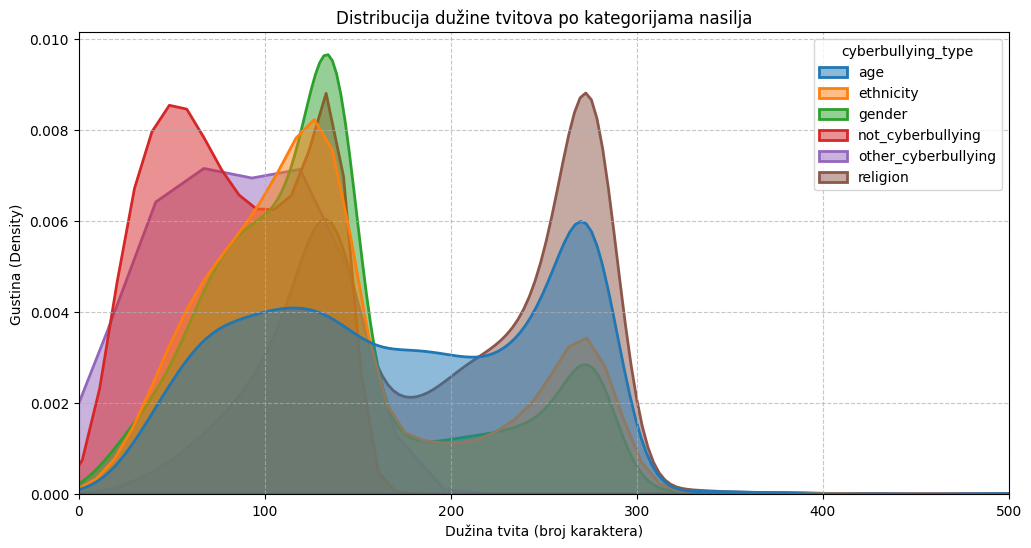

In [ ]:
plt.figure(figsize=(12, 6))
sb.kdeplot(data=data,
           x='tweet_len',
           hue='cyberbullying_type',
           fill=True,
           common_norm=False,
           alpha=0.5,
           linewidth=2)
plt.title('Distribucija dužine tvitova po kategorijama nasilja')
plt.xlabel('Dužina tvita (broj karaktera)')
plt.ylabel('Gustina (Density)')
plt.xlim(0, 500) # Ograničavamo X osu radi preglednosti
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Vizuelizacijom distribucije dužine tvitova utvrđeno je da kategorije nasilja pokazuju različite obrasce u broju korišćenih karaktera. Na primer, nenasilni tvitovi su statistički značajno kraći od onih koji sadrže versku ili etničku diskriminaciju. Ovo opravdava odluku da se u model, pored samog teksta, uključi i numerički podatak o dužini poruke, jer on predstavlja dodatni diskriminativni faktor koji pomaže algoritmu da preciznije razvrsta klase.

In [ ]:
data.head(10)

,tweet_text,cyberbullying_type,tweet_len
0,She looks so beautiful and she’s has a very ki...,age,268
1,My old high school bully just tried to menace ...,age,163
2,From my experience PE teachers are bullies. I ...,age,232
3,ew why is gun/poop girl trending literally go ...,age,165
4,Lara Spencer is so unprofessional. She bullied...,age,256
5,“my two favorite humans” *was probably the gir...,age,84
6,"I truly believe in ""what goes around comes aro...",age,261
7,these are bullies! high school fucking bullies!!,age,48
8,"More than once in middle school, I saw a kid g...",age,132
9,A girl who bullied me and made homophobic comm...,age,235


Sada cemo napraviti funkcije za ciscenje teksta tako sto cemo izbaciti razmake, znakove interpunkcije, brojeve, linkove, tagove.

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"^http\S+", "", text) # uklanjanje linkova
    text = re.sub(r"^#(\S+)", "\\1", text) # uklanjanje # iz hashtagova
    text = re.sub(r"^@(\S+)", "", text) # uklanjanje tagovanja drugih korisnika
    text = re.sub("<[^>]+>", "", text) # uklanjanje HTML tagova
    text = text.strip().lstrip()
    return text

# funkcija za detaljno NLP preprocesiranje (tokenizacija i lematizacija)
def spacy_preprocessing(doc):
    tokens = nlp(doc)
    tokens = [token for token in tokens if ((not token.is_punct) and (not token.is_space) and (not token.like_num) and (not token.like_url))]
    words = [token.lemma_.lower() for token in tokens]
    return words


Pravimo prilagođenu klasu TransformerMixin da bismo mogli da ubacimo clean_text direktno u Pipeline. Takođe pravimo CountVectorizer koji služi za pretvaranje teksta u brojeve, koristeći strategiju brojanja pojavljivanja reči.

In [ ]:
class TextCleaner(TransformerMixin):
    def transform(self, X):
        X['tweet_text'] = [clean_text(txt) for txt in X['tweet_text']]
        return X

    def fit(self, X, y=None):
        return self

def create_count_vectoriser(ngrams=(1,1), min_doc_freq=0.01, f_max=-1):
    vectoriser = CountVectorizer(
        tokenizer=spacy_preprocessing,
        ngram_range=ngrams,
        max_features=f_max if f_max > 0 else None,
        min_df=min_doc_freq
    )
    return vectoriser

Sada pripremamo podatke za treniranje.

In [ ]:
# izdvajanje ulaznih i izlaznih promenljivih
X = data[['tweet_text', 'tweet_len']]
y = data['cyberbullying_type'].values

# enkodiranje kategorija u brojeve
y_encodings, y_levels = pd.factorize(y)

# podela na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encodings, test_size=0.2, random_state=RAND_STATE, stratify=y_encodings
)

U  datasetu, imamo dve različite vrste ulaznih podataka koje zelimo da model vidi:



*   Tekst tvita (tweet_text): On mora da prođe kroz CountVectorizer (da se pretvori u Bag of Words)
*   Dužina tvita (tweet_len): To je običan broj koji ne treba da se pretvara u reči, već samo da se prosledi modelu kao dodatni dokaz.

In [ ]:
count_vectorizer = create_count_vectoriser(ngrams=(1,2))


column_transformer = ColumnTransformer(
    [('word_counts', count_vectorizer, 'tweet_text')],
    remainder='passthrough',
    force_int_remainder_cols=False
)

Kao klasifikator ćemo koristiti Naive Bayes (NB), i to konkretno njegovu Multinomijalnu varijantu.

Ovaj algoritam izračunava verovatnoću da dokument pripada određenoj klasi na osnovu učestalosti svakog termina u tom dokumentu. Ovaj tip klasifikatora se pokazao veoma uspešnim u zadacima klasifikacije teksta; on je izuzetno pogodan za rad sa visokodimenzionalnim i retkim matricama atributa koje nastaju kao rezultat vektorizacije teksta. Takođe, veoma dobro funkcioniše sa relativno malim skupovima podataka.

In [ ]:
classifier = MultinomialNB()

In [ ]:
pipe_1 = Pipeline([
    ('cleaner', TextCleaner()),
    ('vectorizer', column_transformer),
    ('classifier', classifier)
])

In [ ]:
pipe_1.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.TextCleaner object at 0x7ff12f76c950>),
                ('vectorizer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('word_counts',
                                                  CountVectorizer(min_df=0.01,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<function spacy_preprocessing at 0x7ff12d51a660>),
                                                  'tweet_text')])),
                ('classifier', MultinomialNB())])

Prvo cemo uraditi matricu konfuzije

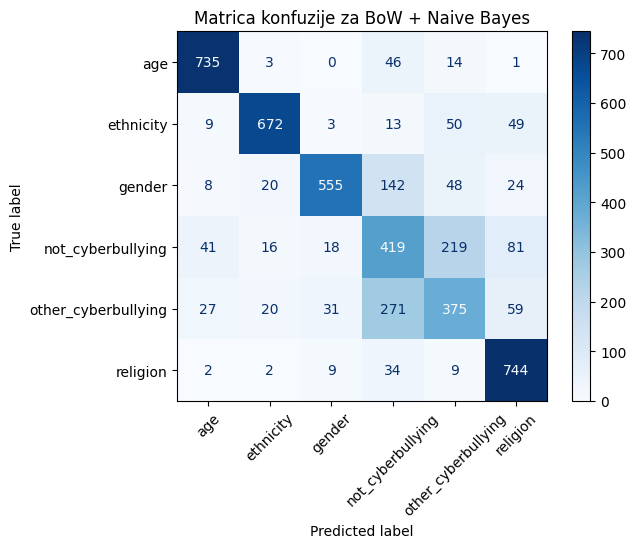

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipe_1,
    X_test,
    y_test,
    display_labels=y_levels,
    cmap='Blues',
    xticks_rotation=45
)
plt.title('Matrica konfuzije za BoW + Naive Bayes')
plt.show()

Matrica konfuzije osnovnog modela jasno ukazuje na visoku sposobnost prepoznavanja strukturiranih oblika nasilja poput verske, etničke i  diskriminacije vezane za uzrast. Međutim, primetno je značajno mešanje (confusion) između kategorija Other Cyberbullying i Not Cyberbullying. Ovo ukazuje na to da suptilniji oblici agresije, koji ne koriste eksplicitne ključne reči, ostaju neprepoznati od strane jednostavnog BoW modela. Ovaj uvid nam potvrđuje potrebu za uvođenjem Word Embeddings pristupa u kasnijim fazama projekta, kako bi model mogao da uči semantički kontekst, a ne samo prisustvo reči.

Sada cemo da racunamo sve predikcije

In [ ]:
predictions_1 = pipe_1.predict(X_test)

report_1 = metrics.classification_report(y_true = y_test, y_pred = predictions_1)
print(report_1)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       799
           1       0.92      0.84      0.88       796
           2       0.90      0.70      0.79       797
           3       0.45      0.53      0.49       794
           4       0.52      0.48      0.50       783
           5       0.78      0.93      0.85       800

    accuracy                           0.73      4769
   macro avg       0.74      0.73      0.73      4769
weighted avg       0.75      0.73      0.74      4769



Model pokazuje visoku preciznost kod kategorija koje koriste specifičan rečnik, kao što su Ethnicity, Religion i Age (0, 1, 5). To je očekivano, jer ovi tvitovi sadrže ključne reči (psovke, verske termine, reci kao sto su: boy, girl, kid, school...) koje su veoma jaki indikatori za algoritam. Najniži F1-score zabeležen je kod kategorije Other Cyberbullying i Not Cyberbullying. Ovo ukazuje na to da je ova klasa 'šumovita' i da ne poseduje jedinstven set reči, već se često preklapa sa drugim oblicima agresivnog ponašanja, što zbunjuje osnovni model.

Balansirana tacnost

In [ ]:
print(f"Balansirana tacnost: {metrics.balanced_accuracy_score(y_test, predictions_1, adjusted=True):0.4f}")

Balansirana tacnost: 0.6794


Postignuta balansirana tačnost od 67.94% ukazuje na to da model poseduje  prediktivnu moć koja je stabilna kroz sve kategorije nasilja. S obzirom na to da je ovaj rezultat dobijen bez optimizacije parametara, on predstavlja čvrstu osnovu koja potvrđuje da su izabrani atributi (tekst i dužina tvita) relevantni za klasifikaciju, ali taj postotak nije savrsen tako da cemo sad pokusati da ga unapredimo sto je vise moguce.

Sada ćemo pokušati da unapredimo performanse klasifikatora menjanjem načina na koji se vrši transformacija teksta (s obzirom na to da sam Multinomial Naive Bayes algoritam ne ostavlja mnogo prostora za fino podešavanje sopstvenih parametara). Neki od hiper-parametara koji se najčešće koriste za tuning su:

   

*   min_df – minimalna učestalost reči u dokumentima (izbacuje previše retke reči)
*   ngram_range – određuje da li koristimo pojedinačne reči ili grupe reči (n-grame) kao atribute.

Mogli bismo da testiramo oba parametra istovremeno, ali bi to zahtevalo previše vremena za izvršavanje. Zato ćemo se fokusirati na jedan i odrediti njegovu optimalnu vrednost pomoću unakrsne validacije (Cross-Validation), koristeći klasu GridSearchCV.

In [ ]:
param_grid = dict(vectorizer__word_counts__min_df=[0.005, 0.01, 0.025])

grid_search = GridSearchCV(pipe_1, param_grid=param_grid, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time= 4.6min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time= 4.2min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time= 4.0min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.005; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time= 3.8min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time= 3.8min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.01; total time= 3.8min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..............vectorizer__word_counts__min_df=0.025; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.05; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.05; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.05; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.05; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ...............vectorizer__word_counts__min_df=0.05; total time= 3.8min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('cleaner',
                                        <__main__.TextCleaner object at 0x7ff12f76c950>),
                                       ('vectorizer',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('word_counts',
                                                                         CountVectorizer(min_df=0.01,
                                                                                         ngram_range=(1,
                                                                                                      2),
                                                                                         tokenizer=<function spacy_preprocessing at 0x7ff12d51a660>),
                                                                         'tweet_text')])),
                                       ('classifier', MultinomialNB())]),
             param_grid={'vectorizer__word_counts__min_df': [0.005, 0.01, 0.025,
                                                             0.05]},
             verbose=2)

In [ ]:
print('\nNajbolji parametri: ', grid_search.best_params_)
print('Najbolji rezultat (Score): ', grid_search.best_score_)


Najbolji parametri:  {'vectorizer__word_counts__min_df': 0.005}
Najbolji rezultat (Score):  0.7498426436525796


Sada cemo pokrenuti pipeline sa tom najboljom vrednoscu

In [ ]:
best_mindf = grid_search.best_params_['vectorizer__word_counts__min_df']

pipe_1.set_params(vectorizer__word_counts__min_df=best_mindf)

pipe_1.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.TextCleaner object at 0x7ff12f76c950>),
                ('vectorizer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('word_counts',
                                                  CountVectorizer(min_df=0.005,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<function spacy_preprocessing at 0x7ff12d51a660>),
                                                  'tweet_text')])),
                ('classifier', MultinomialNB())])

Nove predikcije sa fine-tuned pipeline

In [ ]:
predictions_2 = pipe_1.predict(X_test)
report_2 = metrics.classification_report(y_true=y_test, y_pred=predictions_2, target_names=y_levels)

print(report_2)

                     precision    recall  f1-score   support

                age       0.90      0.93      0.91       799
          ethnicity       0.92      0.86      0.89       796
             gender       0.92      0.71      0.80       797
  not_cyberbullying       0.47      0.54      0.50       794
other_cyberbullying       0.54      0.51      0.52       783
           religion       0.80      0.94      0.86       800

           accuracy                           0.75      4769
          macro avg       0.76      0.75      0.75      4769
       weighted avg       0.76      0.75      0.75      4769



Vidimo blagi skok (1 do 2%) u odnosu na prvi model

Balansirana tacnost


In [ ]:
print(f"Balansirana tacnost(tuned): {metrics.balanced_accuracy_score(y_test, predictions_2, adjusted=True):0.4f}")

Balansirana tacnost(tuned): 0.6971


Nakon sprovedene GridSearchCV optimizacije, postignuta je balansirana tačnost od 69.71%, što predstavlja poboljšanje od približno 2% u odnosu na bazni model. Ovim smo iscrpeli mogućnosti osnovne BoW reprezentacije, čime je opravdan prelazak na TF-IDF i Word Embeddings metode koje bi trebalo da dodatno unaprede prepoznavanje semantički sličnih kategorija.

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=0.01,
    norm="l2",
    use_idf=True,
    smooth_idf=True
)

Kao klasifikator, ponovo ćemo koristiti MultinomialNB

In [ ]:
column_transformer_tfidf = ColumnTransformer(
    [('tf_idf', tf_idf_vectorizer, 'tweet_text')],
    remainder='passthrough'
)

pipe_tfidf = Pipeline([
    ('vectorizer', column_transformer_tfidf),
    ('classifier', classifier)
])

Treniranje TF-IDF-a

In [ ]:
pipe_tfidf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('vectorizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tf_idf',
                                                  TfidfVectorizer(min_df=0.01,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'tweet_text')])),
                ('classifier', MultinomialNB())])

Radimo predikciju i izvestaj

In [ ]:
pred_tfidf = pipe_tfidf.predict(X_test)

print(metrics.classification_report(y_true=y_test, y_pred=pred_tfidf))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       799
           1       0.92      0.85      0.89       796
           2       0.86      0.72      0.78       797
           3       0.49      0.41      0.44       794
           4       0.51      0.48      0.50       783
           5       0.70      0.93      0.80       800

    accuracy                           0.72      4769
   macro avg       0.72      0.72      0.72      4769
weighted avg       0.72      0.72      0.72      4769



Balansirana tacnost

In [ ]:
print(f"Balansirana tacnost: {metrics.balanced_accuracy_score(y_test, pred_tfidf, adjusted=True):0.4f}")

Balansirana tacnost: 0.6683


Uvođenje TF-IDF reprezentacije rezultiralo je padom performansi u poređenju sa optimizovanim CountVectorizer modelom. Balansirana tačnost je pala sa prethodnih ~0.70 na 0.6683.

Razlog za ovo leži u prirodi podataka: tvitovi su kratke forme gde frekvencija ključnih reči (npr. specifičnih uvreda) nosi veoma snažan signal. TF-IDF pokušava da 'kazni' reči koje se često pojavljuju kroz ceo dataset, što u ovom slučaju može oslabiti značaj određenih termina koji su ključni za razlikovanje vrsta nasilja. Takođe, MultinomialNB algoritam se matematički najbolje snalazi sa celobrojnim vrednostima koje daje BoW, dok mu normalizovane decimalne vrednosti TF-IDF-a trenutno manje odgovaraju.

Sada cemo probati i sa ComplementNB da vidimo da li moze situacija da se poboljsa

In [ ]:
# Pravimo novi Pipeline, samo menjamo klasifikator u ComplementNB
pipe_cnb = Pipeline([
    ('vectorizer', column_transformer_tfidf),
    ('classifier', ComplementNB())
])

pipe_cnb.fit(X_train, y_train)
pred_cnb = pipe_cnb.predict(X_test)

print(metrics.classification_report(y_true=y_test, y_pred=pred_cnb,  target_names=y_levels))
print(f"Balansirana tacnost: {metrics.balanced_accuracy_score(y_test, pred_cnb, adjusted=True):0.4f}")

              precision    recall  f1-score   support

           0       0.75      0.97      0.84       799
           1       0.87      0.95      0.91       796
           2       0.81      0.72      0.77       797
           3       0.53      0.34      0.42       794
           4       0.53      0.32      0.40       783
           5       0.66      0.96      0.78       800

    accuracy                           0.71      4769
   macro avg       0.69      0.71      0.69      4769
weighted avg       0.69      0.71      0.69      4769

Balansirana tacnost: 0.6536


Vidimo da je balansirana tacnost dodatno pala na 0.6536 Problematične klase: Primetno je da klase 3 i 4 (not_cyberbullying i other_cyberbullying) imaju drastično niži recall (0.34 i 0.32). To znači da model sada promašuje više od dve trećine nasilja u tim kategorijama sto je veoma lose i nema poente praviti model.

# Korišćenje "Word Embeddings" modela za reprezentaciju dokumenata

Sada imamo način da numerički predstavimo svaku reč – embeddings (ugrađeni vektori) nam pružaju vektor za svaku reč u našem rečniku.

Međutim, da bismo izvršili klasifikaciju, potrebna nam je numerička reprezentacija celih tweetova. Dakle, za svaki tweet nam je potreban vektor koji bi ga predstavljao, a taj vektor treba da bude zasnovan na vektorima reči koje se nalaze u tom tweety. Ovde cemo to uraditi izračunavanjem proseka vektora svih reči koje čine recenziju.

### Kreiranje klase za transformaciju (Custom Transformer)

Kreiraćemo klasu TweetVectorizer koja transformiše svaki tweet u vektorsku reprezentaciju, kao što je gore opisano, koristeći unapred obučeni Word2Vec model.

In [ ]:
class TweetVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, spacy_pipeline):
        self.spacy_pipeline = spacy_pipeline
        self.D = len(self.spacy_pipeline.vocab['word'].vector)

    @staticmethod
    def report_unmatched_words_stats(dropped_docs_list, unmatched_words_dict, total_docs):
        unmatched_counts = [len(unmatched) for unmatched in unmatched_words_dict.values()]

        if len(unmatched_counts) > 0:
            print(f"Prosečan broj nepronađenih reči po tvitu: {mean(unmatched_counts):.4f} (SD: {stdev(unmatched_counts):.4f})")
        else:
            print("Sve reči su uspešno pronađene u rečniku!")

        dropped_cnt = len(dropped_docs_list)
        if dropped_cnt > 0:
            proporcija = (dropped_cnt / total_docs) * 100
            print(f"Broj tvitova bez ijedne poznate reči: {dropped_cnt} ({proporcija:.2f}%)")
        print("----------------------------\n")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        unmatched_words = defaultdict(list)
        dropped_indices = []
        X_transformed = np.zeros((len(X), self.D))

        for i, text in enumerate(X):
            words = str(text).split()
            vecs = []

            for word in words:
                lexeme = self.spacy_pipeline.vocab[word]
                if lexeme.has_vector:
                    vecs.append(lexeme.vector)
                else:
                    unmatched_words[i].append(word)

            if len(vecs) > 0:
                vecs = np.array(vecs)
                X_transformed[i] = vecs.mean(axis=0)
            else:
                dropped_indices.append(i)

        self.report_unmatched_words_stats(dropped_indices, unmatched_words, len(X))

        return X_transformed

Koristimo klasu TweetVectorizer kako bi se transformisali tvitovi u vektore pomoću modela word embeddings. Koristimo RobustScaler za ponovno skaliranje dva dodatna atributa (koristeći medijanu i interkvartilni opseg) tako da svi atributi budu u približno istom opsegu vrednosti. Zatim možemo iskoristiti dobijeni skup atributa za izgradnju klasifikatora.

In [ ]:
vectorizer = TweetVectorizer(spacy_pipeline=nlp)
normaliser = RobustScaler()

column_transformer = ColumnTransformer(
    transformers=[
        ('embeddings', vectorizer, 'tweet_text'),
        ('other_features', normaliser, ['tweet_len']),
    ])

Sada cemo da koristimo model RandomForestClassifier

In [ ]:
rf_classifier = RandomForestClassifier(random_state=1, n_estimators=100)
smote = SMOTE(random_state=1)

rf_pipe = Pipeline([
        ('vectorizer', column_transformer),
        ('resampling', smote),
        ('classifier', rf_classifier)
     ])

rf_pipe.fit(X_train, y_train)

Prosečan broj nepronađenih reči po tvitu: 3.5800 (SD: 3.0483)
Broj tvitova bez ijedne poznate reči: 251 (1.32%)
----------------------------



Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  TweetVectorizer(spacy_pipeline=<spacy.lang.en.English object at 0x7ff18ee90530>),
                                                  'tweet_text'),
                                                 ('other_features',
                                                  RobustScaler(),
                                                  ['tweet_len'])])),
                ('resampling', SMOTE(random_state=1)),
                ('classifier', RandomForestClassifier(random_state=1))])

Dijagnostika rečnika pokazala je da korišćeni en_core_web_lg model pokriva veliku većinu korišćenog rečnika, pri čemu samo 1.32% tvitova nije moglo biti predstavljeno vektorom zbog nedostatka poznatih reči. Prosečan broj nepoznatih reči po poruci iznosi 3.58, što je prihvatljivo za nestrukturisane podatke sa Twittera koji obiluju žargonom i specifičnom interpunkcijom. Ovo potvrđuje visoku reprezentativnost izabranih vektorskih obeležja za dalju klasifikaciju.

In [ ]:
rf_predictions = rf_pipe.predict(X_test)

print(metrics.classification_report(y_test, rf_predictions, target_names=y_levels))

Prosečan broj nepronađenih reči po tvitu: 3.5914 (SD: 2.5315)
Broj tvitova bez ijedne poznate reči: 50 (1.05%)
----------------------------

                     precision    recall  f1-score   support

                age       0.91      0.94      0.92       799
          ethnicity       0.87      0.82      0.85       796
             gender       0.76      0.67      0.72       797
  not_cyberbullying       0.48      0.47      0.47       794
other_cyberbullying       0.47      0.51      0.49       783
           religion       0.84      0.90      0.87       800

           accuracy                           0.72      4769
          macro avg       0.72      0.72      0.72      4769
       weighted avg       0.72      0.72      0.72      4769



In [ ]:
bacc_rf = metrics.balanced_accuracy_score(y_test, rf_predictions, adjusted=True)
print(f"Balansirana preciznost: {bacc_rf:0.4f}")

Balansirana preciznost: 0.6642


Vidimo da nasi rezultati ne ukazuju na neku promenu i da je mozda najbolja stvar raditi sto jednostavnije jer trosi manje vremena i moze imati cak bolje rezultate. Medjutim, ostaje nam poslednja nada da dobijemo jos bolje rezultate.

## Support Vector Machines (SVM)
Ovog puta ćemo koristiti klasifikator Support Vector Machines (SVM). Ovaj tip klasifikatora se pokazao uspešnim u zadacima klasifikacije teksta.

Koristićemo najjednostavniju verziju ovog klasifikatora — SVM sa linearnim kernelom. Ovaj tip klasifikatora implementiran je pomoću sklearn klase SVC sa parametrom kernel='linear'.

In [ ]:
svm_classifier = SVC(
    kernel='linear',
    C=1,
    random_state=1
)

svm_pipe = Pipeline([
    ('vectorizer', column_transformer),
    ('resampling', smote),
    ('classifier', svm_classifier)
], verbose=True)


In [ ]:
svm_pipe.fit(X_train, y_train)

Prosečan broj nepronađenih reči po tvitu: 3.5800 (SD: 3.0483)
Broj tvitova bez ijedne poznate reči: 251 (1.32%)
----------------------------

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total=  15.8s
[Pipeline] ........ (step 2 of 3) Processing resampling, total=   1.4s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  54.8s


Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  TweetVectorizer(spacy_pipeline=<spacy.lang.en.English object at 0x7ff18ee90530>),
                                                  'tweet_text'),
                                                 ('other_features',
                                                  RobustScaler(),
                                                  ['tweet_len'])])),
                ('resampling', SMOTE(random_state=1)),
                ('classifier', SVC(C=1, kernel='linear', random_state=1))],
         verbose=True)

In [ ]:
svm_predictions = svm_pipe.predict(X_test)

print(metrics.classification_report(y_test, svm_predictions, target_names=y_levels))
print(f"Balansirana preciznost: {metrics.balanced_accuracy_score(y_test, svm_predictions, adjusted=True):0.4f}")

Prosečan broj nepronađenih reči po tvitu: 3.5914 (SD: 2.5315)
Broj tvitova bez ijedne poznate reči: 50 (1.05%)
----------------------------

                     precision    recall  f1-score   support

                age       0.94      0.96      0.95       799
          ethnicity       0.91      0.91      0.91       796
             gender       0.82      0.75      0.78       797
  not_cyberbullying       0.55      0.49      0.52       794
other_cyberbullying       0.54      0.65      0.59       783
           religion       0.93      0.91      0.92       800

           accuracy                           0.78      4769
          macro avg       0.78      0.78      0.78      4769
       weighted avg       0.78      0.78      0.78      4769

Balansirana preciznost: 0.7335


Ovi rezultati jasno ukazuju na to da kombinacija Word Embeddings reprezentacije i SVM klasifikatora predstavlja najuspešniju arhitekturu za ovaj problem. Za razliku od prethodnih modela, SVM je uspeo da postigne do sada najveću balansiranu preciznost od 0.7335.

Posebno je značajan napredak u prepoznavanju kategorija poput other_cyberbullying, gde je model pokazao bolju sposobnost razdvajanja suptilnih uvreda od običnog teksta u odnosu na Random Forest.

Međutim, iako je osnovni model sa podrazumevanom vrednošću parametra C=1 pokazao odlične rezultate, postoji prostor za dodatnu optimizaciju. Kako bismo osigurali da model nije ni previše 'opušten', ali ni previše 'krut', prelazimo na fino podešavanje hiperparametara putem GridSearchCV metode. Ovaj korak će nam omogućiti da pronađemo matematički najoptimalniju vrednost parametra C.

## Optimizacija SVC modela podešavanjem hiperparametara

Model klasifikacije možemo pokušati da unapredimo putem podešavanja hiperparametara. Konkretno, ispitaćemo opseg vrednosti za hiperparametar C. Ovim parametrom određujemo koliku kaznu model dobija za pogrešno klasifikovane tačke – što je veća vrednost C, to je kazna veća, ali se istovremeno povećava i rizik od overfitting-a.

Podešavanje ćemo izvršiti pomoću Grid Search-a nad zadatim opsegom vrednosti parametra C.

In [ ]:
param_grid = dict(classifier__C=[0.1, 1, 10])

grid_search = GridSearchCV(svm_pipe, param_grid=param_grid, scoring='recall_macro', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Prosečan broj nepronađenih reči po tvitu: 3.5768 (SD: 3.1326)
Broj tvitova bez ijedne poznate reči: 203 (1.33%)
----------------------------

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total=  12.6s
[Pipeline] ........ (step 2 of 3) Processing resampling, total=   0.9s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  37.9s
Prosečan broj nepronađenih reči po tvitu: 3.5931 (SD: 2.6859)
Broj tvitova bez ijedne poznate reči: 48 (1.26%)
----------------------------

[CV] END ..................................classifier__C=0.1; total time= 1.0min
Prosečan broj nepronađenih reči po tvitu: 3.5779 (SD: 2.8937)
Broj tvitova bez ijedne poznate reči: 199 (1.30%)
----------------------------

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total=  11.7s
[Pipeline] ........ (step 2 of 3) Processing resampling, total=   1.6s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  33.7s
Prosečan

GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        ColumnTransformer(transformers=[('embeddings',
                                                                         TweetVectorizer(spacy_pipeline=<spacy.lang.en.English object at 0x7ff18ee90530>),
                                                                         'tweet_text'),
                                                                        ('other_features',
                                                                         RobustScaler(),
                                                                         ['tweet_len'])])),
                                       ('resampling', SMOTE(random_state=1)),
                                       ('classifier',
                                        SVC(C=1, kernel='linear',
                                            random_state=1))],
                                verbose=True),
             param_grid={'classifier__C': [0.1, 1, 10]}, scoring='recall_macro',
             verbose=2)

In [ ]:
print(f"\nNajbolji parametri: {grid_search.best_params_}")
print(f"Najbolji recall_macro na treningu: {grid_search.best_score_:0.4f}")


Najbolji parametri: {'classifier__C': 1}
Najbolji recall_macro na treningu: 0.7723


Vidimo da smo ovom kompleksom analizom dosli do zakljucka da nam je parametar C=1 najbolji, sa njim smo vec bili odradili analizu tako da smo zavrsili sa testiranjem. Sada sledi zakljucak.

In [ ]:
model_reports = [
    ("TF-IDF + MultinomialNB", pred_tfidf),
    ("TF-IDF + ComplementNB", pred_cnb),
    ("Word Embeddings + Random Forest", rf_predictions),
    ("Word Embeddings + SVC", svm_predictions),
    ("Word Embeddings + SVC (Optizovan)", svm_opt_predictions),
    ("BoW + Naive Bayes", predictions_1),
    ("BoW + MultinomialNB", predictions_2)
]

final_results = []

for name, y_pred in model_reports:
    acc = metrics.accuracy_score(y_test, y_pred)
    f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
    b_acc = metrics.balanced_accuracy_score(y_test, y_pred, adjusted=True)

    final_results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Macro F1-Score': round(f1_macro, 4),
        'Balanced Accuracy': round(b_acc, 4)
    })

df_comparison = pd.DataFrame(final_results).set_index('Model')

# prikaz sortirane tabele po najboljem rezultatu
display(df_comparison.sort_values(by='Balanced Accuracy', ascending=False))

,Accuracy,Macro F1-Score,Balanced Accuracy
Model,,,
Word Embeddings + SVC,0.7786,0.7785,0.7335
Word Embeddings + SVC (Optizovan),0.7786,0.7785,0.7335
BoW + MultinomialNB,0.7486,0.7488,0.6971
BoW + Naive Bayes,0.7339,0.7343,0.6794
TF-IDF + MultinomialNB,0.7247,0.7166,0.6683
Word Embeddings + Random Forest,0.7211,0.7207,0.6642
TF-IDF + ComplementNB,0.7129,0.6861,0.6536


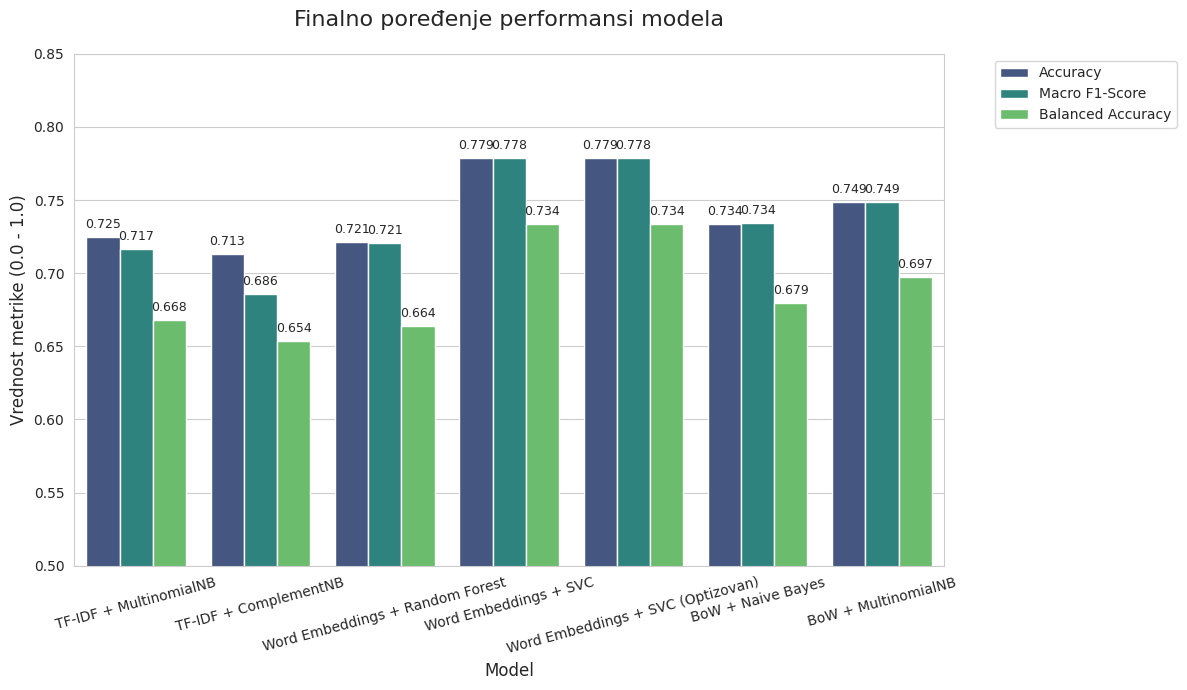

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df_comparison.reset_index().melt(id_vars='Model', var_name='Metrika', value_name='Vrednost')

plt.figure(figsize=(12, 7))
sb.set_style("whitegrid")

ax = sb.barplot(data=df_plot, x='Model', y='Vrednost', hue='Metrika', palette='viridis')

plt.title('Finalno poređenje performansi modela', fontsize=16, pad=20)
plt.ylabel('Vrednost metrike (0.0 - 1.0)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.ylim(0.5, 0.85)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=9)

plt.tight_layout()
plt.show()

Zaključak

Kroz ovo istraživanje sprovedena je detaljna komparativna analiza različitih tehnika obrade prirodnog jezika i algoritama mašinskog učenja u cilju detekcije i klasifikacije internet nasilja. S obzirom na prirodu problema i važnost ravnopravnog prepoznavanja svih kategorija nasilja, Macro F1-Score je korišćen kao primarna metrika za evaluaciju uspešnosti modela.

Analiza rezultata ukazuje na sledeće ključne zaključke:

*   Kombinacija Word Embeddings reprezentacije i SVC algoritma pokazala se kao ubedljivo najuspešnija arhitektura, ostvarivši najviši Macro F1-Score od 0.7785. Ovaj model je uspeo da najbolje iskoristi visokodimenzionalni semantički prostor za povlačenje preciznih granica između složenih klasa. Dodatno, pokušaj optimizacije hiperparametara ovog modela rezultirao je identičnim performansama (F1: 0.7785), što naučno potvrđuje izuzetnu stabilnost modela na podrazumevanim vrednostima (C=1).

*   Moć jednostavnosti (BoW baseline): Modeli bazirani na prostom brojanju reči (Bag of Words), a posebno BoW + MultinomialNB, ostvarili su izuzetno visok i konkurentan Macro F1-Score od 0.7488. Ovo potvrđuje pretpostavku da u kratkim formama komunikacije, poput tvitova, samo prisustvo specifičnih ključnih reči (npr. uvreda ili psovki) predstavlja veoma snažan signal za klasifikaciju.
*   Ograničenja TF-IDF i stabala odlučivanja: Pokazalo se da uvođenje TF-IDF normalizacije ne donosi benefit na ovom specifičnom skupu podataka. Najslabije performanse u celom eksperimentu zabeležio je TF-IDF + ComplementNB sa Macro F1 rezultatom od svega 0.6861. Slično tome, Random Forest algoritam nad Word Embeddings vektorima (F1: 0.7207) nije uspeo da isprati efikasnost linearnog SVM-a.

Projekat uspešno demonstrira da se prelazak sa čistih statističkih metoda (prebrojavanje reči) na napredne semantičke modele (vektorsko predstavljanje značenja) isplati samo kada je uparen sa adekvatnim klasifikatorom sposobnim da te podatke obradi, kao što je to u našem slučaju učinio SVM.